# Behavioral Cloning
## CSE 485 - Deep Learning
### Done By Hazem Ayman Mohamed 18P2696 and Mariam Mahmoud Fawzi 18P1092

### Objective

In this project, a deep neural network was trained to steer a car in a game simulator autonomously. Data is collected by driving the car in the track manually and training the neural network using this data to predict the steering angle of the car during the driving phase.

### Imported Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D , Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D , ReLU , MaxPool2D
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from data_preprocessing import * 
%load_ext tensorboard

### Reading csv file

In [ ]:
Csvfile = 'data/data_3/driving_log.csv'
imagesDIR = 'data/data'

### Data Preprocessing and Augmentation

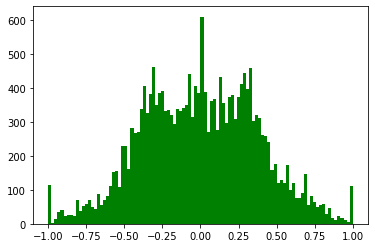

In [2]:
dataset = preprocessing(Csvfile , imagesDIR)

## Histogram of the steering angle

**Removing the largest bin (bins=1)**

20499
19949


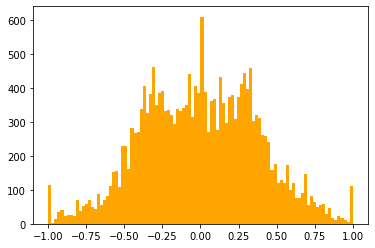

In [3]:
dataset.clearBins(bins = 1)

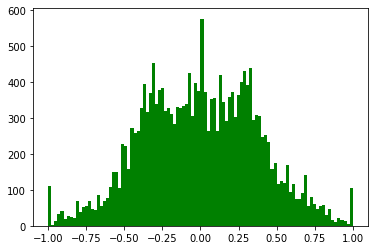

In [4]:
dataset.showHistogram()

**Subsampling the data**

In [5]:
dataset.subsampling()

390 19949 0.01954985212291343
19559


**Generating the batch**

In [6]:
## Batch size = 2000
DataGenerator = dataset.Generator(2000)

In [7]:
y = next(DataGenerator)

19559


**Histogram of final data distribution**

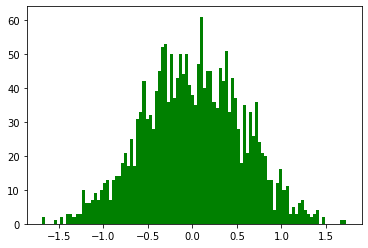

In [8]:
n, _, _ = plt.hist(y[1], 100, facecolor='green')
plt.show()

### Model Architecture

Model architecture used was based on the Nvidia paper **"End to End Learning for Self-Driving Cars"**.

Source: https://arxiv.org/pdf/1604.07316v1.pdf

The architecture consists of a normalization layer, 5 convolutional layers, and 3 fully connected layers. The model was built using tensorflow and keras. 

While training the model we tried an ELU activation function and a ReLU activation function, ReLU gave better results.

We also tried batch normalization layer instead of dropout but it didn't give better results. 


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
def create_model():
    ch, row, col = 3, 64, 64  # camera format
    INIT='glorot_uniform' # 'he_normal', glorot_uniform
    keep_prob = 0.2
    reg_val = 0.01
    
    model = Sequential()
    #normalization layer
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(row, col, ch),
            output_shape=(row, col, ch)))
    # first 3 convolutional -> kernel size 5x5 and stride 2x2 with no padding
    # the model has a drop out layer with probability 0.2 in each state and a ReLU activation function
    model.add(Conv2D(24, 5, 2,  padding="valid", kernel_initializer=INIT, kernel_regularizer=l2(reg_val)))
    W_regularizer=l2(reg_val)
#     model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(keep_prob))

    model.add(Conv2D(36, 5, 2 ,padding="valid", kernel_initializer=INIT))
#     model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(keep_prob))
    
    model.add(Conv2D(48, 5, 2 , padding="valid", kernel_initializer=INIT))
#     model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(keep_prob))

    # last 2 convolutional layers -> kernel size 3x3 and no stride and no padding
    model.add(Conv2D(64, 3, 1, kernel_initializer=INIT))
#     model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(keep_prob))

    model.add(Conv2D(64, 3, 1, kernel_initializer=INIT))
#     model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(keep_prob))
    
    # 3 fully connected layers
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100))
    model.add(ReLU())
    model.add(Dropout(0.2))
    
    model.add(Dense(50))
    model.add(ReLU())
    model.add(Dropout(0.2))
    
    model.add(Dense(10))
    model.add(ReLU())
    
    model.add(Dense(1))
    

    
    return model

In [10]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 24)        1824      
                                                                 
 re_lu (ReLU)                (None, 30, 30, 24)        0         
                                                                 
 dropout (Dropout)           (None, 30, 30, 24)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 36)        21636     
                                                                 
 re_lu_1 (ReLU)              (None, 13, 13, 36)        0         
                                                                 
 dropout_1 (Dropout)         (None, 13, 13, 36)        0

**Updating weights by Adam Optimizer**

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse") # , metrics=['accuracy']

In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=6,verbose=0, mode='min')
checkpoint = ModelCheckpoint('checkpoints_2/'+'model'+'-{epoch:02d}-{val_loss:.4f}',  monitor='val_loss'
                             ,verbose=0, save_best_only=True, 
                             save_weights_only=False, mode='auto')

The batch size of both the training data and validation size is 256 image. We are not really worried about overfitting in our problem therefore the training data and the validation data are not 2 separate datasets.

In [19]:
my_samples_gen = dataset.Generator(batchSize=256)
validation_batch = dataset.Generator(batchSize=256)
# we train the model for 30 epochs
EPOCHS = 30

In [20]:
# try:
#     model.load_weights('checkpoints_2/model-07-0.0630')
    
# except IOError:
#     print ('no previous model found....\n')

In [21]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
## model is trained for 30 epochs with 100 step per epoch
model.fit(
                my_samples_gen,
                steps_per_epoch=300,
                epochs=EPOCHS,
                validation_data=validation_batch,
                validation_steps =5 ,
                verbose=1,
                callbacks=[early_stop, checkpoint,tensorboard_callback]
            )

19559
Epoch 1/30
107/300 [=========>....................] - ETA: 2:57 - loss: 0.0703

In [ ]:
## saving the model
model.save('model'+'.h5', True)
%tensorboard --logdir logs/fit

In [ ]:
# model.load_weights('checkpoints_2/model-07-0.0630')